## Feature extraction from images

we want to extract features from shapes by turning them into time seires.

#### importing the modules

In [1]:
import numpy as np
import matplotlib.image as mpimg # reading images
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from skimage import measure # to find shape
import scipy.ndimage as ndi # image processing
from pylab import rcParams

In [2]:
%matplotlib inline
rcParams['figure.figsize'] = (3, 3)   # setting default size of plots

#### reading image file

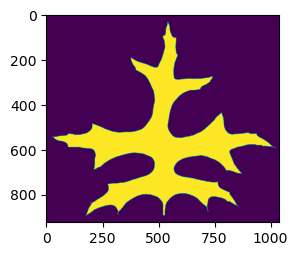

In [3]:
img= mpimg.imread('images/53.jpg')
plt.imshow(img)

#### using image processing module of scipy to find center of leaf
* scipy.ndimage is a multi-dimensional image processing tool.
* It is mainly used for image filtering, measurements, and morphology.
* It can be used for tasks such as smoothing, sharpening, edge detection, and noise reduction in images.

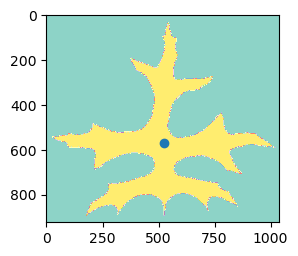

In [4]:
cy,cx = ndi.center_of_mass(img)
plt.imshow(img,cmap='Set3')  
plt.scatter(cx, cy)          
plt.show()

#### finding edges of leaf
* from sickit-learn we use measure to find the contour
* we identify the boundaries of the leaf within the image, using a threshold value of 0.8 to determine which pixels belong to the leaf.

In [5]:
contours = measure.find_contours(img, .8)
contour = max(contours, key=len)

In [6]:
contour

array([[896.99686275, 179.        ],
       [896.99686275, 178.        ],
       [896.        , 177.00313725],
       ...,
       [895.        , 179.99686275],
       [896.        , 179.99686275],
       [896.99686275, 179.        ]])

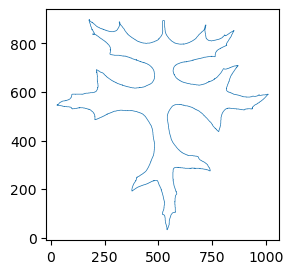

In [7]:
plt.plot(contour[::,1], contour[::,0], linewidth=0.5)  

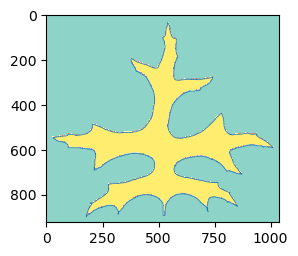

In [8]:
plt.plot(contour[::,1], contour[::,0], linewidth=0.5)  
plt.imshow(img, cmap='Set3')
plt.show()

### generating time-series

#### project this contour (pairs of x,y coordinstes) into the polar coordinate system
* we represent each point using polar coordinates (r, $\theta$ ) instead of Cartesian coordinates.
* In polar coordinates, 'r' represents the distance from the origin to the point, and '$\theta$ ' represents the angle measured from the positive x-axis to the line segment connecting the origin to the point.
* formulas-
    * x = r cos($\theta$)
    * y = r sin($\theta$)
    * $x^2 + y^2 = r^2 $
* polar coordinates make it easy to identify features and charectitics of contour

converting cartesian to polar coordinates

In [9]:
def cart2pol(x,y):
    r=np.sqrt(x**2+y**2)
    theta=np.arctan2(y,x)
    return[r,theta]

In [10]:
polar_contour=np.array([cart2pol(x,y) for x,y in contour])

#### plotting polar coordinates

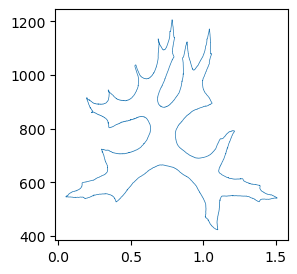

In [11]:
plt.plot(polar_contour[::,1],polar_contour[::,0],linewidth=0.5)
plt.show()

we wanted a time series but got a leaf instead.

#### trying again but move leaf to (0,0) this time
* we Demean the contour data (subtracting mean from each data point to make the overall mean to zero)
* Demean is needed becuase: the polar coordnate projection failed to yield what we want, because the shape is in the +,+ part of the Cartesian system, not around the center.

#### demean

In [12]:
contour[::,1] -= cx  # demean X
contour[::,0] -= cy  # demean Y

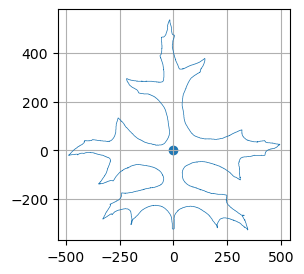

In [13]:
plt.plot(-contour[::,1], -contour[::,0], linewidth=0.5)
plt.grid()
plt.scatter(0, 0)
plt.show()

#### projecting new cartesian coordinates into polar space

In [14]:
# conversion
polar_contour = np.array([cart2pol(x, y) for x, y in contour])

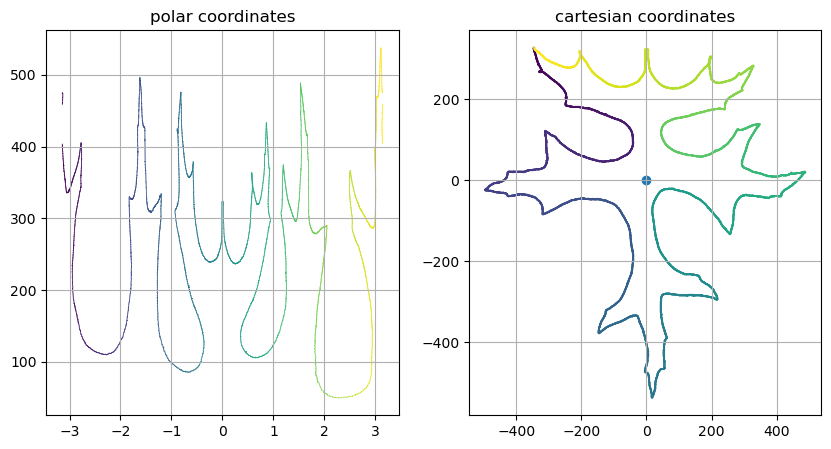

In [15]:
# visualisation
rcParams['figure.figsize'] = (10,5)
plt.subplot(121)
plt.scatter(polar_contour[::,1],polar_contour[::,0],s=0.5,linewidth=0,c=polar_contour[::,1])
plt.title('polar coordinates')
plt.grid()

plt.subplot(122)
plt.scatter(contour[::,1],contour[::,0],linewidth=0,s=2,c=range(len(contour)))
plt.scatter(0,0)
plt.title('cartesian coordinates')
plt.grid()
plt.show()

this is not a time series yet

#### using scikitlearn image feature extractions 
* corner_harris - Detects corners in an image
* corner_subpix - Refines corner positions detected by an initial method and improves accuracy
* corner_peaks - Identifies strongest corners after corner detection.
* CENSURE - Identifies points of interest based on local extremas in intensity 

In [16]:
from skimage.feature import corner_harris, corner_subpix, corner_peaks, CENSURE

from skimage.feature import corner_harris, corner_subpix, corner_peaks, CENSURE


CENSURE().detect(img)

coords = corner_peaks(corner_harris(img), min_distance=5)
coords_subpix = corner_subpix(img, coords, window_size=13)

plt.subplot(121)
plt.title('CENSURE feature detection')
plt.imshow(img, cmap='Set3')
plt.scatter(detector.keypoints[:, 1], detector.keypoints[:, 0],
              2 ** detector.scales, facecolors='none', edgecolors='r')

plt.subplot(122)
plt.title('Harris Corner Detection')
plt.imshow(img, cmap='Set3')  # show me the leaf
plt.plot(coords[:, 1], coords[:, 0], '.b', markersize=5)
plt.show()

#### finding local maxima and minima

argrelextrema finds indices of local extrema (peaks or valleys) in an array.

In [17]:
from scipy.signal import argrelextrema

In [18]:
c_max_index= argrelextrema(polar_contour[::,0],np.greater,order=50)
c_min_index= argrelextrema(polar_contour[::,0],np.less,order=50)

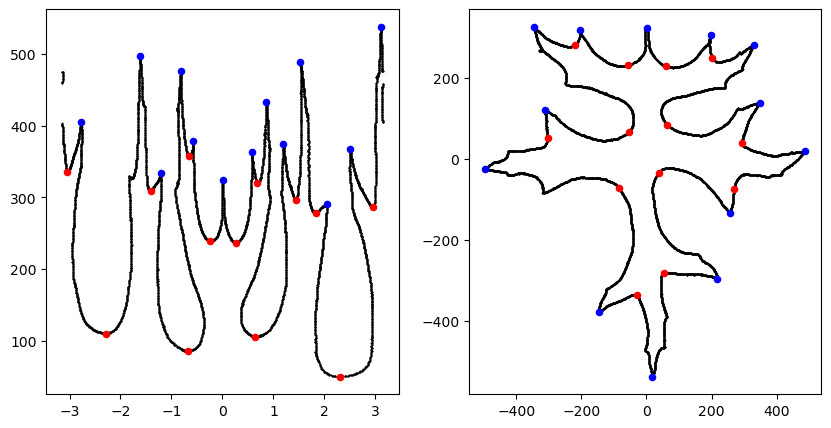

In [19]:
plt.subplot(121)
plt.scatter(polar_contour[::,1],polar_contour[::,0],linewidth=0,s=2,c='k')
plt.scatter(polar_contour[::,1][c_max_index],polar_contour[::,0][c_max_index],linewidth=0, s=30, c='b')
plt.scatter(polar_contour[::,1][c_min_index],polar_contour[::,0][c_min_index],linewidth=0, s=30, c='r')

plt.subplot(122)
plt.scatter(contour[::,1], contour[::,0],linewidth=0, s=2, c='k')
plt.scatter(contour[::,1][c_max_index],contour[::,0][c_max_index],linewidth=0, s=30, c='b')
plt.scatter(contour[::,1][c_min_index],contour[::,0][c_min_index],linewidth=0, s=30, c='r')

plt.show()


finds the points with the geatest distance from the center but not the tip of leaf

#### mathematical morphology functions
* Erosion: Shrinks the boundaries of objects in an image by removing pixels near the object edges.
* Dilation: Expands the boundaries of objects in an image by adding pixels near the object edges.

* Opening: Removes small objects and smooths boundaries by performing an erosion followed by a dilation.

* Closing: Fills small gaps and smooths object boundaries by performing a dilation followed by an erosion.

In [20]:
def cont(img):
    return max(measure.find_contours(img, .8), key=len)

# let us set the brush to a 6x6 circle
struct = [[ 0., 0., 1., 1., 0., 0.],
          [ 0., 1., 1., 1., 1., 0.],  
          [ 1., 1., 1., 1., 1., 1.], 
          [ 1., 1., 1., 1., 1., 1.], 
          [ 1., 1., 1., 1., 1., 1.], 
          [ 0., 1., 1., 1., 1., 0.],
          [ 0., 0., 1., 1., 0., 0.]]

In [21]:
from scipy.ndimage import binary_erosion, binary_closing, binary_opening, binary_dilation

erosion = cont(binary_erosion(img, structure=struct).astype(img.dtype))
closing = cont(binary_closing(img, structure=struct).astype(img.dtype))
opening = cont(binary_opening(img, structure=struct).astype(img.dtype))
dilation = cont(binary_dilation(img, structure=struct).astype(img.dtype))

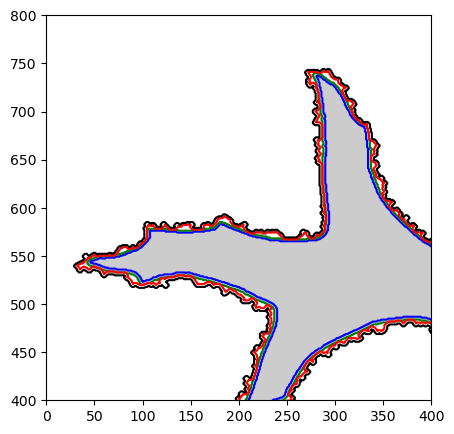

In [22]:
plt.imshow(img.T, cmap='Greys', alpha=.2)
plt.plot(erosion[::,0], erosion[::,1], c='b')
plt.plot(opening[::,0], opening[::,1], c='g')
plt.plot(closing[::,0], closing[::,1], c='r')
plt.plot(dilation[::,0], dilation[::,1], c='k')
plt.xlim([0, 400])
plt.ylim([400, 800])
plt.show()

there is noise around the edge of original image

#### check if noise is present 

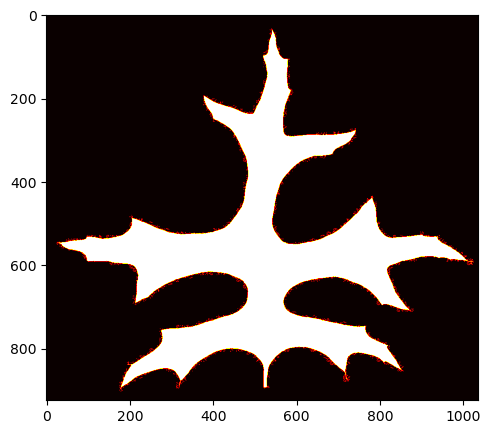

In [23]:
plt.imshow(img.astype(bool).astype(float), cmap='hot')
plt.show()

#### removing noise

In [24]:
# pixels with value greater than 254 are set to true(foreground) and < 254 to false(background)
erosion = cont(binary_erosion(img > 254, structure=struct).astype(img.dtype))
closing = cont(binary_closing(img > 254, structure=struct).astype(img.dtype))
opening = cont(binary_opening(img > 254, structure=struct).astype(img.dtype))
dilation = cont(binary_dilation(img > 254, structure=struct).astype(img.dtype))

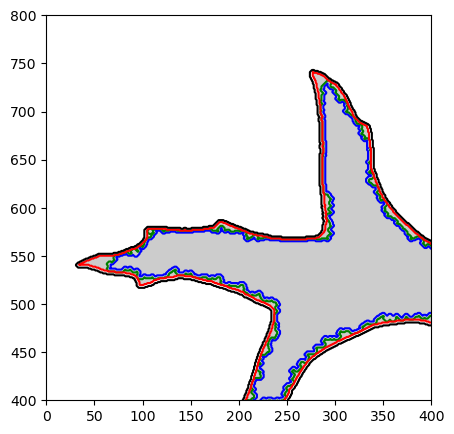

In [25]:
plt.imshow(img.T, cmap='Greys', alpha=.2)
plt.plot(erosion[::,0], erosion[::,1], c='b')
plt.plot(opening[::,0], opening[::,1], c='g')
plt.plot(closing[::,0], closing[::,1], c='r')
plt.plot(dilation[::,0], dilation[::,1], c='k')
plt.xlim([0, 400])
plt.ylim([400, 800])
plt.show()

from 2 morphology tests, it is clear:
* the leaf has debris around its edge
* there are no 100% white pixels at the edge

we use the red contour line as the base

#### finding core shape of leaf and edge texture

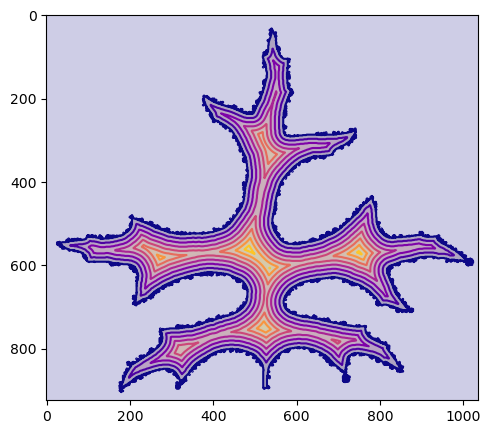

In [26]:
# calculates the distance of each non-zero (foreground) pixel to the nearest zero (background) pixel
dist_2d = ndi.distance_transform_edt(img)
plt.imshow(img, cmap='Greys', alpha=.2)
plt.imshow(dist_2d, cmap='plasma', alpha=.2)
plt.contour(dist_2d, cmap='plasma')
plt.show()

## Reading image file - 2

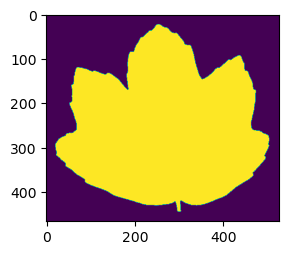

In [27]:
rcParams['figure.figsize'] = (3, 3)
img2= mpimg.imread('images/1.jpg')
plt.imshow(img2)

#### finding center of image

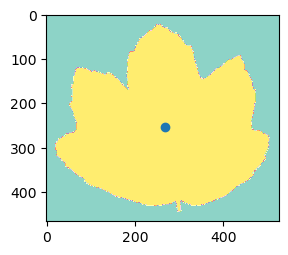

In [28]:
cy,cx = ndi.center_of_mass(img2)
plt.imshow(img2,cmap='Set3')  
plt.scatter(cx, cy)          
plt.show()

#### finding edge of leaf

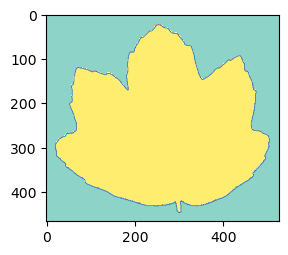

In [29]:
contours = measure.find_contours(img2, .8)
contour = max(contours, key=len)
plt.plot(contour[::,1], contour[::,0], linewidth=0.5) 
plt.imshow(img2, cmap='Set3')
plt.show()

#### moving centre to (0,0)

In [30]:
contour[::,1] -= cx  # demean X
contour[::,0] -= cy  # demean Y

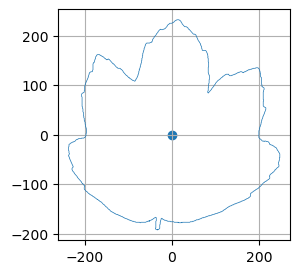

In [31]:
plt.plot(-contour[::,1], -contour[::,0], linewidth=0.5)
plt.grid()
plt.scatter(0, 0)
plt.show()

### perofrming mathematical morphology

#### checking for noise

In [32]:
rcParams['figure.figsize'] = (5, 5)

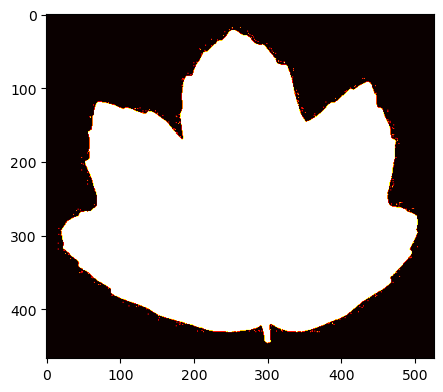

In [33]:
plt.imshow(img2.astype(bool).astype(float), cmap='hot')
plt.show()

noise exists

#### removing noise and applying functions

In [34]:
def cont(img2):
    return max(measure.find_contours(img2, .8), key=len)

struct = [[ 0., 0., 1., 1., 0., 0.],
          [ 0., 1., 1., 1., 1., 0.],  
          [ 1., 1., 1., 1., 1., 1.], 
          [ 1., 1., 1., 1., 1., 1.], 
          [ 1., 1., 1., 1., 1., 1.], 
          [ 0., 1., 1., 1., 1., 0.],
          [ 0., 0., 1., 1., 0., 0.]]


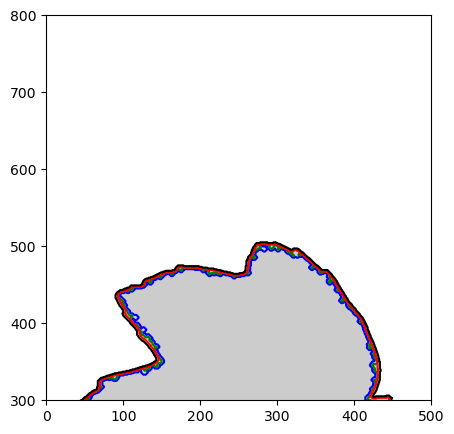

In [35]:
erosion = cont(binary_erosion(img2 > 254, structure=struct).astype(img.dtype))
closing = cont(binary_closing(img2 > 254, structure=struct).astype(img.dtype))
opening = cont(binary_opening(img2 > 254, structure=struct).astype(img.dtype))
dilation = cont(binary_dilation(img2 > 254, structure=struct).astype(img.dtype))

plt.imshow(img2.T, cmap='Greys', alpha=.2)
plt.plot(erosion[::,0], erosion[::,1], c='b')
plt.plot(opening[::,0], opening[::,1], c='g')
plt.plot(closing[::,0], closing[::,1], c='r')
plt.plot(dilation[::,0], dilation[::,1], c='k')
plt.xlim([0, 500])
plt.ylim([300, 800])
plt.show()

#### finding core shape if leaf and edge texture

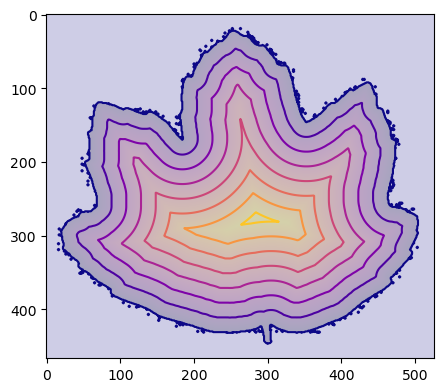

In [36]:
dist_2d = ndi.distance_transform_edt(img2)
plt.imshow(img2, cmap='Greys', alpha=.2)
plt.imshow(dist_2d, cmap='plasma', alpha=.2)
plt.contour(dist_2d, cmap='plasma')
plt.show()